In [58]:
# 일단 2015데이터로 학습, 예측

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno
import numpy  as np
import seaborn as sns
%matplotlib inline

path = './data/'
pd.options.display.max_rows = 150
pd.options.display.max_columns = 350
plt.rc('font',family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False

In [3]:
sido = pd.read_csv(path+'sido_imp_10.csv', encoding='cp949')

In [4]:
sido_y = sido.iloc[:,-7:]
sido_x = sido.iloc[:,3:-7]
sido_name = sido.iloc[:,:3]

### 표준화

In [5]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
sido_x_scaled = scaler.fit_transform(sido_x)

In [6]:
sido_x_scaled = pd.DataFrame(data = sido_x_scaled)
sido_x_scaled.columns = sido_x.columns
sido_x_scaled.shape

(17, 163)

### 스코어함수들
    - kfold_crossvalscore(): kfold의 평균 스코어들을 한번에 출력되도록 함
    - metric_score(): 분류메트릭을 이용한 스코어들을 한번에 출력되도록 함
    - paper(): 얼만큼 맞췄는지 확인해보려고
    - confusion_matrix
    - classification report
    - model.score()

스코어나오는 함수 설정

In [7]:
#교차검증 실험 crossvalscore이용
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
cv = KFold(3, shuffle=True, random_state=0)
def KFold_meanscore(ary):
    tot = 0
    for i in ary:
        tot += i
    return print(tot/len(ary),ary)
def kfold_crossvalscore(model, X, y, cv=cv):
    ary1 = cross_val_score(model, X, y, cv=cv, scoring='f1')
    ary2 = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
    ary3 = cross_val_score(model, X, y, cv=cv, scoring='precision')
    ary4 = cross_val_score(model, X, y, cv=cv, scoring='recall')
    print(f'f1-score:{KFold_meanscore(ary1)}')
    print(f'accuracy:{KFold_meanscore(ary2)}')
    print(f'precision:{KFold_meanscore(ary3)}')
    print(f'recall:{KFold_meanscore(ary4)}')

In [25]:
#분류메트릭이용
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

def metric_score(y, pred):
    print(f'f1 :\t\t{f1_score(y,pred)}')
    print(f'accuracy :\t{accuracy_score(y,pred)}')
    print(f'precision :\t{precision_score(y, pred)}')
    print(f'recall :\t{recall_score(y, pred)}')

In [26]:
#정답지
def paper(y, pred):
    a = pd.DataFrame(data=pred,columns=['예측'])
    b = pd.DataFrame(data=y)
    return pd.concat([a,b],axis=1)

In [ ]:
#confusion matrix
confusion_matrix = pd.crosstab(sido.감염병, pred_mlp, rownames=['True'], colnames=['Predicted'], margins=True)
confusion_matrix

In [ ]:
#classification report
from sklearn.metrics import classification_report
print(classification_report(sido.감염병,pred_mlp, target_names=['123','45']))

# MLP

In [28]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(50,30))
mlp.fit(sido_x_scaled, sido.감염병)
pred_mlp = mlp.predict(sido_x_scaled)

In [29]:
mlp.score(sido_x_scaled, sido.감염병) #모델에 트레이닝셋을 적용했을때 평균정확도(accuracy) 반환

1.0

In [30]:
confusion_matrix = pd.crosstab(sido.감염병, pred_mlp, rownames=['True'], colnames=['Predicted'], margins=True)
confusion_matrix

Predicted,0,1,All
True,,,
0,11,0,11
1,0,6,6
All,11,6,17


In [31]:
#crossvalscore이용
kfold_crossvalscore(mlp, sido_x_scaled, sido.감염병)

C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


0.4000000000000001 [0.4 0.  0.8]
f1-score:None
0.8222222222222223 [0.66666667 1.         0.8       ]
accuracy:None
0.5 [0.5 0.  1. ]
precision:None
0.38888888888888884 [0.5        0.         0.66666667]
recall:None


In [32]:
#분류메트릭이용
metric_score(sido.감염병, pred_mlp)

f1 :		1.0
accuracy :	1.0
precision :	1.0
recall :	1.0


In [33]:
#classification report
from sklearn.metrics import classification_report
print(classification_report(sido.감염병,pred_mlp, target_names=['123','45']))

              precision    recall  f1-score   support

         123       1.00      1.00      1.00        11
          45       1.00      1.00      1.00         6

    accuracy                           1.00        17
   macro avg       1.00      1.00      1.00        17
weighted avg       1.00      1.00      1.00        17



In [34]:
#정답지
paper(sido.감염병, pred_mlp)

,예측,감염병
0,0,0
1,0,0
2,0,0
3,1,1
4,0,0
5,1,1
6,0,0
7,1,1
8,0,0
9,1,1


# RFC

In [35]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=10).fit(sido_x_scaled, sido.감염병)
rfc.fit(sido_x_scaled, sido.감염병)
pred_rfc = rfc.predict(sido_x_scaled)

# XGB

In [36]:
from xgboost import XGBClassifier
xgb = XGBClassifier(max_depth=10, n_estimators=200, learning_rate=0.01)
xgb.fit(sido_x_scaled, sido.감염병)
pred_xgb = xgb.predict(sido_x_scaled)

# LGBM

In [38]:
from lightgbm import LGBMClassifier
import copy#lgbm은 아스키 코드값만 입력받기 때문에 한글을 다 숫자로 바뀌주기
lgbm_sido = b = copy.deepcopy(sido_x_scaled) 
lgbm_sido.columns = list(range(163))
lgbm= LGBMClassifier(n_estimators=200,num_boost_round =500,learning_rate =0.01)
lgbm.fit(lgbm_sido, sido.감염병)
pred_lgbm = lgbm.predict(sido_x_scaled)

C:\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


# SVC

In [39]:
from sklearn.svm import SVC
svc = SVC(gamma=0.0001, C=3000, probability=True)
svc.fit(sido_x_scaled, sido.감염병)
pred_svc = svc.predict(sido_x_scaled)

In [40]:
print(classification_report(sido.감염병,pred_svc, target_names=['123','45']))

              precision    recall  f1-score   support

         123       1.00      1.00      1.00        11
          45       1.00      1.00      1.00         6

    accuracy                           1.00        17
   macro avg       1.00      1.00      1.00        17
weighted avg       1.00      1.00      1.00        17



# Logistic Regression

In [41]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(sido_x_scaled, sido.감염병)
pred_lr = lr.predict(sido_x_scaled)

C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [42]:
print(classification_report(sido.감염병,pred_lr, target_names=['123','45']))

              precision    recall  f1-score   support

         123       1.00      1.00      1.00        11
          45       1.00      1.00      1.00         6

    accuracy                           1.00        17
   macro avg       1.00      1.00      1.00        17
weighted avg       1.00      1.00      1.00        17



# Perceptron

In [74]:
from sklearn.linear_model import Perceptron
pcp = Perceptron()
pcp.fit(sido_x_scaled, sido.감염병)
pred_pcp = pcp.predict(sido_x_scaled)

# Decision Tree

In [44]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier()
dtc.fit(sido_x_scaled, sido.감염병)
pred_dtc = pcp.predict(sido_x_scaled)

# AUC / ROC

In [80]:
#AUC: AreaUnderCurve는 1에 가까울 수록 좋음
from sklearn.metrics import roc_curve
fpr1, tpr1, thresholds1 = roc_curve(sido.감염병, lr.decision_function(sido_x_scaled))
fpr2, tpr2, thresholds2 = roc_curve(sido.감염병, svc.decision_function(sido_x_scaled))
fpr3, tpr3, thresholds3 = roc_curve(sido.감염병, pcp.decision_function(sido_x_scaled))
#no mlp, xgb, dtc, lgbm, rfc

In [79]:
from sklearn.metrics import auc
auc(fpr1,tpr1), auc(fpr2, tpr2), auc(fpr3, tpr3)
#auc of model1, auc of model2

(1.0, 1.0, 1.0)

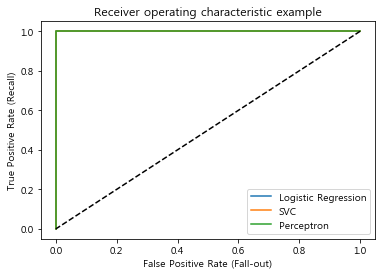

In [82]:
#roc커브 시각화
plt.title('Receiver operating characteristic example')
plt.xlabel('False Positive Rate (Fall-out)')
plt.ylabel('True Positive Rate (Recall)')
plt.plot(fpr1, tpr1, label='Logistic Regression')
plt.plot(fpr2, tpr2, label='SVC')
plt.plot(fpr3, tpr3, label='Perceptron')
plt.legend()

plt.plot([1,0],[1,0],'k--',label='random gu ess') ## 수정해야됨

# GridSearchCV

In [ ]:
from sklearn.feature_selection import SelectKBest
model_kbest = SelectKBest()
from sklearn.pipeline import Pipeline

### cv: MLP

In [ ]:
pipe_mlp = Pipeline([("kbest", model_kbest),('mlp',mlp)])
#파라미터 생성
params_mlp = {"kbest__k":[163],
          "mlp__hidden_layer_sizes": [(50,30),(20,40,20),(30,50)],
         "mlp__learning_rate": [0.01,0.05]}

In [ ]:
grid_search = GridSearchCV(pipe_mlp, param_grid = params_mlp,
                          cv=3, n_jobs=-1, verbose=1)

In [ ]:
grid_search.fit(sido_x_scaled, sido.감염병)
mlp_grid = grid_search.best_estimator_
mlp_grid

### cv: RFC

In [ ]:
pipe_rfc = Pipeline([("kbest", model_kbest),('rfc',rfc)])
#파라미터 생성
params_rfc = {"kbest__k":[163],
          "rfc__max_depth": [10,15,20,25],
         "rfc__learning_rate": [0.01,0.05],
         "rfc__n_estimators": [200,300,400,500]}

In [ ]:
grid_search = GridSearchCV(pipe_rfc, param_grid = params_rfc,
                          cv=3, n_jobs=-1, verbose=1)

In [ ]:
grid_search.fit(sido_x_scaled, sido.감염병)
rfc_grid = grid_search.best_estimator_
rfc_grid

### cv: xgb

In [69]:
pipe_xgb = Pipeline([("kbest", model_kbest),('xgb',xgb)])
#파라미터 생성
params_xgb = {"kbest__k":[163],
          "xgb__max_depth": [10,15,20,25],
         "xgb__learning_rate": [0.01,0.05],
         "xgb__n_estimators": [200,300,400,500]}

In [70]:
grid_search = GridSearchCV(pipe_xgb, param_grid = params_xgb,
                          cv=3, n_jobs=-1, verbose=1)

In [71]:
grid_search.fit(sido_x_scaled, sido.감염병)

Fitting 3 folds for each of 32 candidates, totalling 96 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:    1.6s finished
C:\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('kbest',
                                        SelectKBest(k=10,
                                                    score_func=<function f_classif at 0x0000000017AA70D0>)),
                                       ('xgb',
                                        XGBClassifier(base_score=0.5,
                                                      booster='gbtree',
                                                      colsample_bylevel=1,
                                                      colsample_bynode=1,
                                                      colsample_bytree=1,
                                                      gamma=0,
                                                      learning_rate=0.01,
                                                      max_delta_step=0,
                                                      max_depth=10

In [72]:
xgb_grid = grid_search.best_estimator_
xgb_grid

Pipeline(memory=None,
         steps=[('kbest',
                 SelectKBest(k=163,
                             score_func=<function f_classif at 0x0000000017AA70D0>)),
                ('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, learning_rate=0.01,
                               max_delta_step=0, max_depth=10,
                               min_child_weight=1, missing=None,
                               n_estimators=200, n_jobs=1, nthread=None,
                               objective='binary:logistic', random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               seed=None, silent=None, subsample=1,
                               verbosity=1))],
         verbose=False)

In [84]:
kfold_crossvalscore(xgb_grid, sido_x_scaled, sido.감염병)

C:\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: UserWarning: Features [110] are constant.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: UserWarning: Features [110] are constant.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: UserWarning: Features [110] are constant.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: UserWarn

0.38888888888888884 [0.5        0.         0.66666667]
f1-score:None
0.5333333333333333 [0.66666667 0.33333333 0.6       ]
accuracy:None
0.38888888888888884 [0.5        0.         0.66666667]
precision:None
0.38888888888888884 [0.5        0.         0.66666667]
recall:None


### cv: lgbm

In [73]:
#최적의 변수를 찾기 위한 KBest 함수 불러오기
#파이프라인 구축
pipe_lgbm = Pipeline([("kbest", model_kbest),('lgbm',lgbm)])
#파라미터 생성
params_lgbm = {"kbest__k":[163],
          "lgbm__max_depth": [15,20,25],
         "lgbm__learning_rate": [0.05],
         "lgbm__num_leaves": [15,20,25],
         "lgbm__n_estimators": [200,300,400,500],
         "lgbm__random_state": [42]}

In [65]:
#최적의 파라미터 탐색
from sklearn.model_selection import GridSearchCV
grid_search = GridSearchCV(pipe_lgbm, param_grid = params_lgbm,
                          cv=3, n_jobs=-1, verbose=10)

In [66]:
grid_search.fit(sido_x_scaled, sido.감염병)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1860s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0834s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done  60 out of 108 | elapsed:    2.2s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:    2.3s finished
C:\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('kbest',
                                        SelectKBest(k=10,
                                                    score_func=<function f_classif at 0x0000000017AA70D0>)),
                                       ('lgbm',
                                        LGBMClassifier(boosting_type='gbdt',
                                                       class_weight=None,
                                                       colsample_bytree=1.0,
                                                       importance_type='split',
                                                       learning_rate=0.01,
                                                       max_depth=-1,
                                                       min_child_samples=20,
                                                       min_child_weight=0.001,...
                            

In [67]:
lgbm_grid = grid_search.best_estimator_
lgbm_grid

Pipeline(memory=None,
         steps=[('kbest',
                 SelectKBest(k=163,
                             score_func=<function f_classif at 0x0000000017AA70D0>)),
                ('lgbm',
                 LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                colsample_bytree=1.0, importance_type='split',
                                learning_rate=0.05, max_depth=15,
                                min_child_samples=20, min_child_weight=0.001,
                                min_split_gain=0.0, n_estimators=200, n_jobs=-1,
                                num_boost_round=500, num_leaves=15,
                                objective=None, random_state=42, reg_alpha=0.0,
                                reg_lambda=0.0, silent=True, subsample=1.0,
                                subsample_for_bin=200000, subsample_freq=0))],
         verbose=False)

### cv: lr

In [85]:
pipe_lr = Pipeline([("kbest", model_kbest),('lr',lr)])
#파라미터 생성
params_lr = {"kbest__k":[163],
          "lr__tol": [0.0001,0.0005,0.001],
         "lr__max_iter": [50,100,150]}

### cv: dtc

### cv: pcp

### cv: pcp

### cv: svc